# Load and initialise libraries

In [ ]:
import os
os.environ['R_HOME'] = "/usr/lib/R/"
import anndata2ri
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.set_figure_params(dpi_save=600)
anndata2ri.activate()
%load_ext rpy2.ipython

# R data type to anndata

In [4]:
%%R -o adata
load("_Output/adata_SGN.RData")

In [5]:
leiden=pd.read_csv("_Output/SGN_leiden.csv",index_col=0)

In [6]:
adata.obs["leiden"]=leiden.loc[adata.obs_names].values
adata.obs["leiden"]=adata.obs["leiden"].astype("category")

... storing 'devtime' as categorical


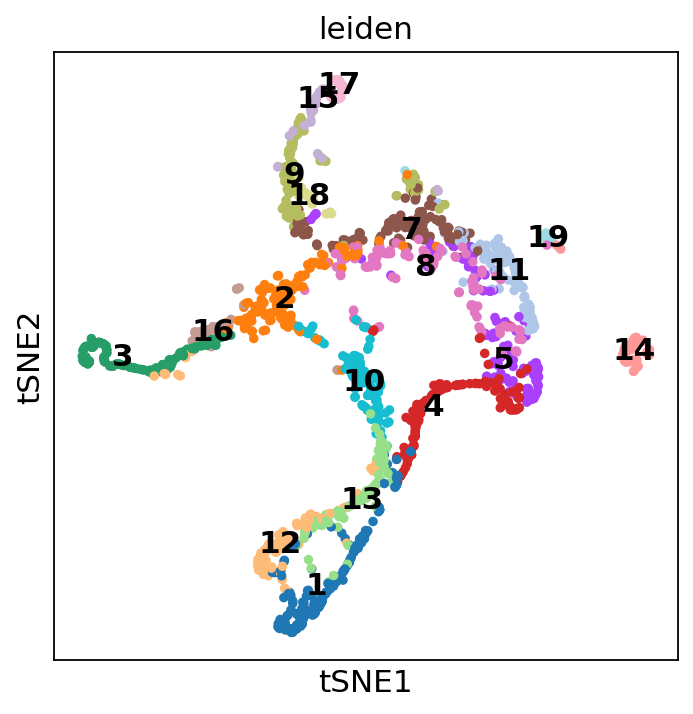

In [7]:
sc.set_figure_params(figsize=(5,5))
sc.pl.tsne(adata,color="leiden",legend_loc="on data")

In [10]:
adata.obs["leiden"]=adata.obs["leiden"].cat.rename_categories(np.array([14,15,
11,12,13,
8,9,10,
5,6,7,
2,1,3,4,
18,16,17]))

In [11]:
pal=[ "#417239","#88EA75",
  "#375575","#669ED6","#A0CBE8",
  "#B24145","#FD5B49","#EDB6B6",
  "#cf33ff","#ff4ff6","#F4ADE4",
  "#CFB53B","#fcf4a3","#fff200","#fcd12a",
  "#917924","#79706E","#BAB0AC"]

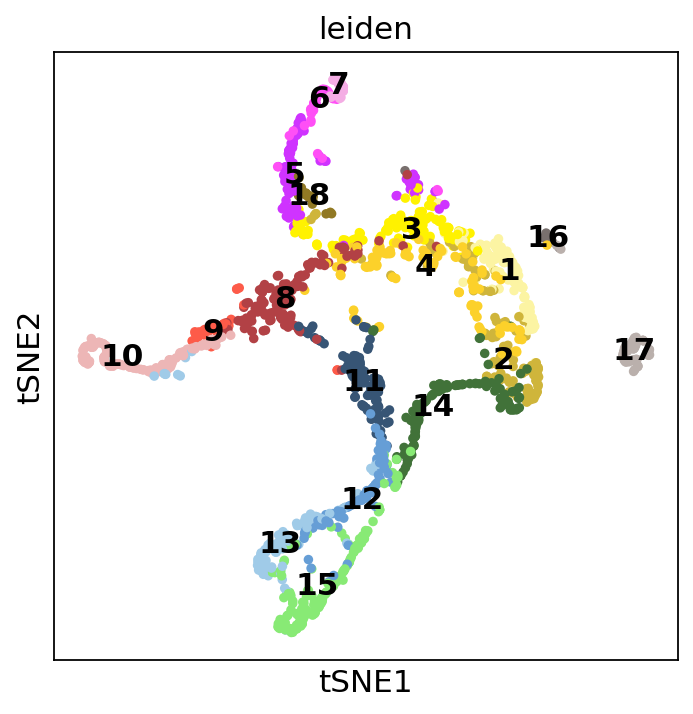

In [12]:
sc.set_figure_params(figsize=(5,5))
sc.pl.tsne(adata,color="leiden",palette=pal,legend_loc="on data")

In [15]:
adata=adata[~adata.obs.leiden.isin([18])]

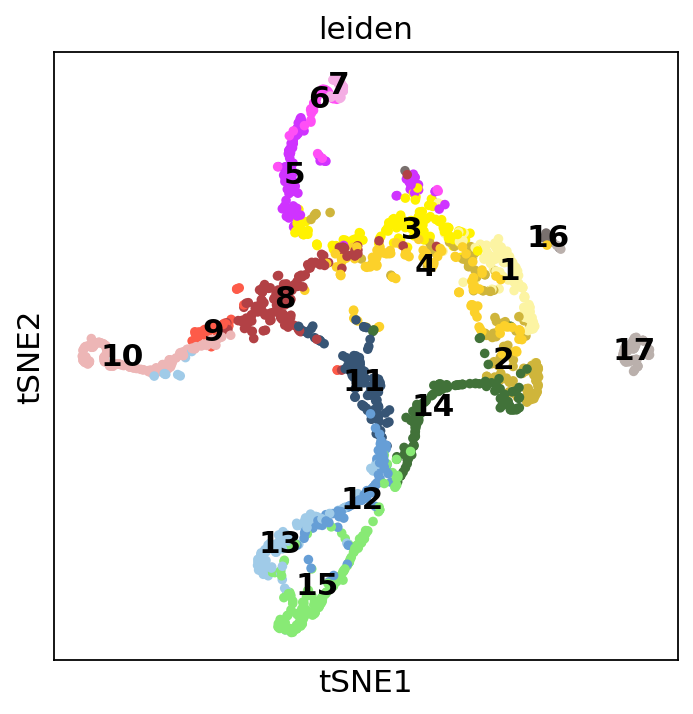

In [16]:
sc.set_figure_params(figsize=(5,5))
sc.pl.tsne(adata,color="leiden",legend_loc="on data")

## Overview plots

Trying to set attribute `.uns` of view, copying.


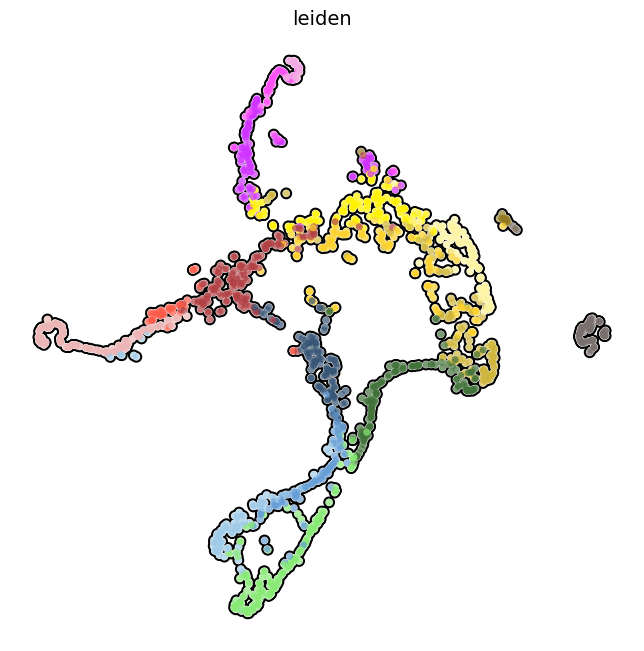

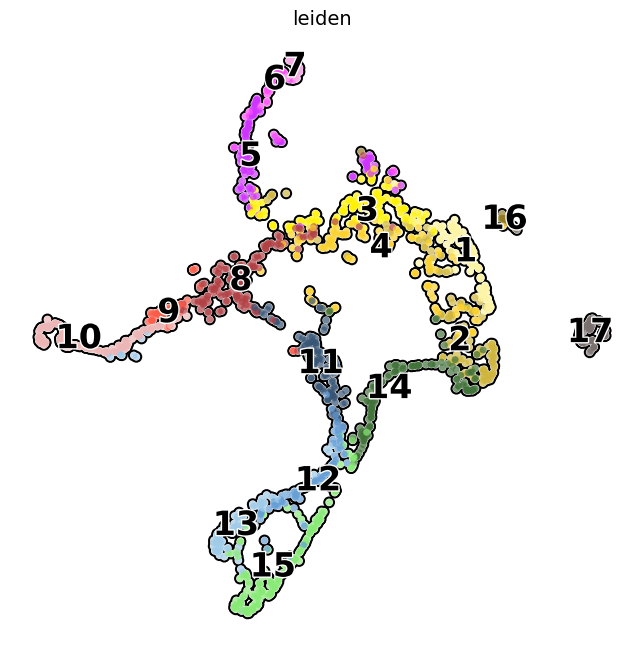

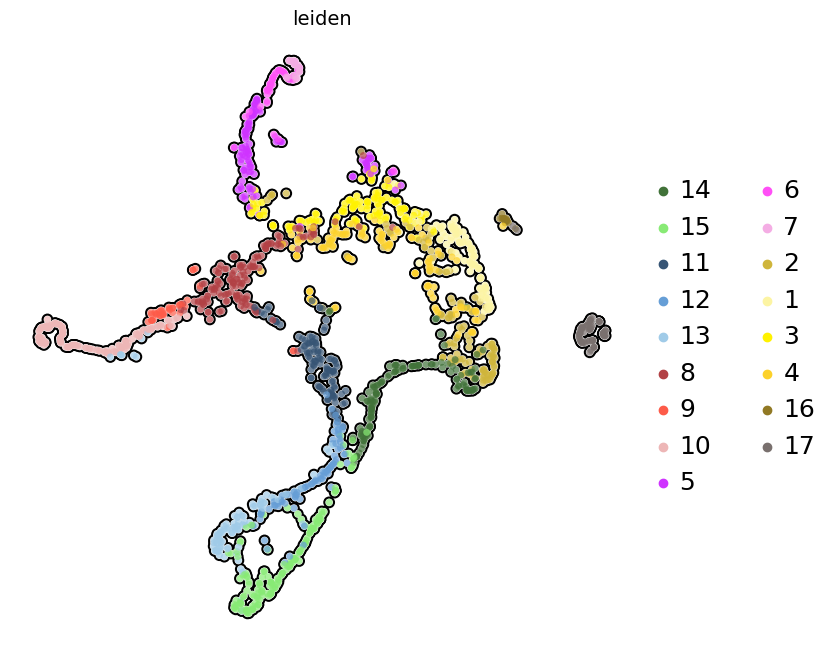

In [17]:
sc.set_figure_params(figsize=(8,8),dpi=50,dpi_save=600)
sc.pl.tsne(adata, color='leiden', add_outline=True, legend_loc='none',
           legend_fontsize=12, legend_fontoutline=2,frameon=False,size =100,
           title='leiden', palette=pal,save="_leiden.png")
sc.pl.tsne(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=24, legend_fontoutline=2,frameon=False,size =100,
           title='leiden', palette=pal,save="_leiden2.png")
sc.pl.tsne(adata, color='leiden', add_outline=True,
           legend_fontsize=18, legend_fontoutline=2,frameon=False,size =100,
           title='leiden', palette=pal,save="_leiden3.png")

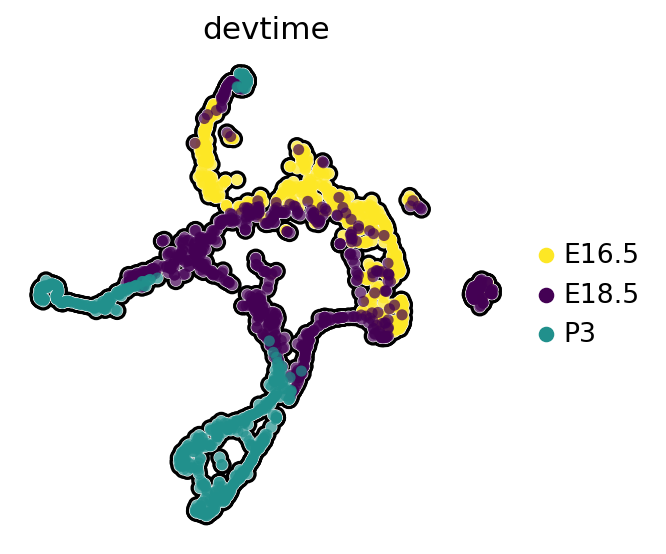

In [50]:
sc.pl.tsne(adata, color='devtime', add_outline=True,
           legend_fontsize=12, legend_fontoutline=2,frameon=False,size =100,
           title='devtime',palette=["#FDE725FF","#440154FF","#21908CFF"],save="_devtime.png")

## Loading and scaling scde corrected data

In [18]:
fpm=pd.read_csv("_Output/fpm.csv",index_col=0)
adata=adata[:,adata.var_names.isin(fpm.index)]
adata.layers["fpm"]=fpm.loc[:,adata.obs_names].T.values

In [19]:
adata.layers["scaled"]=sc.pp.scale(adata.layers["fpm"],copy=True)
adata.write_h5ad("_Output/adata_SGN.h5ad")

In [45]:
import scanpy as sc
adata=sc.read("_Output/adata_SGN.h5ad")

In [61]:
adata.obs.leiden=adata.obs.leiden.cat.reorder_categories(adata.obs.leiden.cat.categories.sort_values())

In [62]:
sc.tl.rank_genes_groups(adata,"leiden",method="wilcoxon",use_raw=False,layer="fpm")

In [19]:
%%R -o raw -o cellid -o genes
load("_Output/res_scde.RData")
raw = exp(scde::scde.expression.magnitude(res_scde$knn, res_scde$cd))
cellid = colnames(raw)
genes = rownames(raw)

In [85]:
raw=pd.DataFrame(raw,index=genes, columns=cellid)

raw=raw.loc[:,adata.obs_names]

def get_demean(cl):
    df_test=sc.get.rank_genes_groups_df(adata,group=str(cl),pval_cutoff=0.05).set_index("names")
    df_test["mean_raw_fpm"]=raw.loc[df_test.index,adata.obs.leiden==cl].mean(axis=1).values

    other_clu=adata.obs.leiden.cat.categories[adata.obs.leiden.cat.categories!=cl]

    tt=list(map(lambda clu: raw.loc[df_test.index,adata.obs.leiden==clu].mean(axis=1).values,other_clu))
    tomerge=pd.DataFrame(tt,columns=df_test.index,index=["mean_norm_fpm "+str(c) for c in other_clu]).T

    return pd.concat([df_test,tomerge],axis=1)

from p_tqdm import p_map

alldemean=p_map(get_demean,adata.obs.leiden.cat.categories)

writer = pd.ExcelWriter('All_DE.xlsx', engine='xlsxwriter')
for cl in adata.obs.leiden.cat.categories:
    alldemean[cl-1].to_excel(writer, sheet_name="Leiden "+str(cl))
    
writer.save()

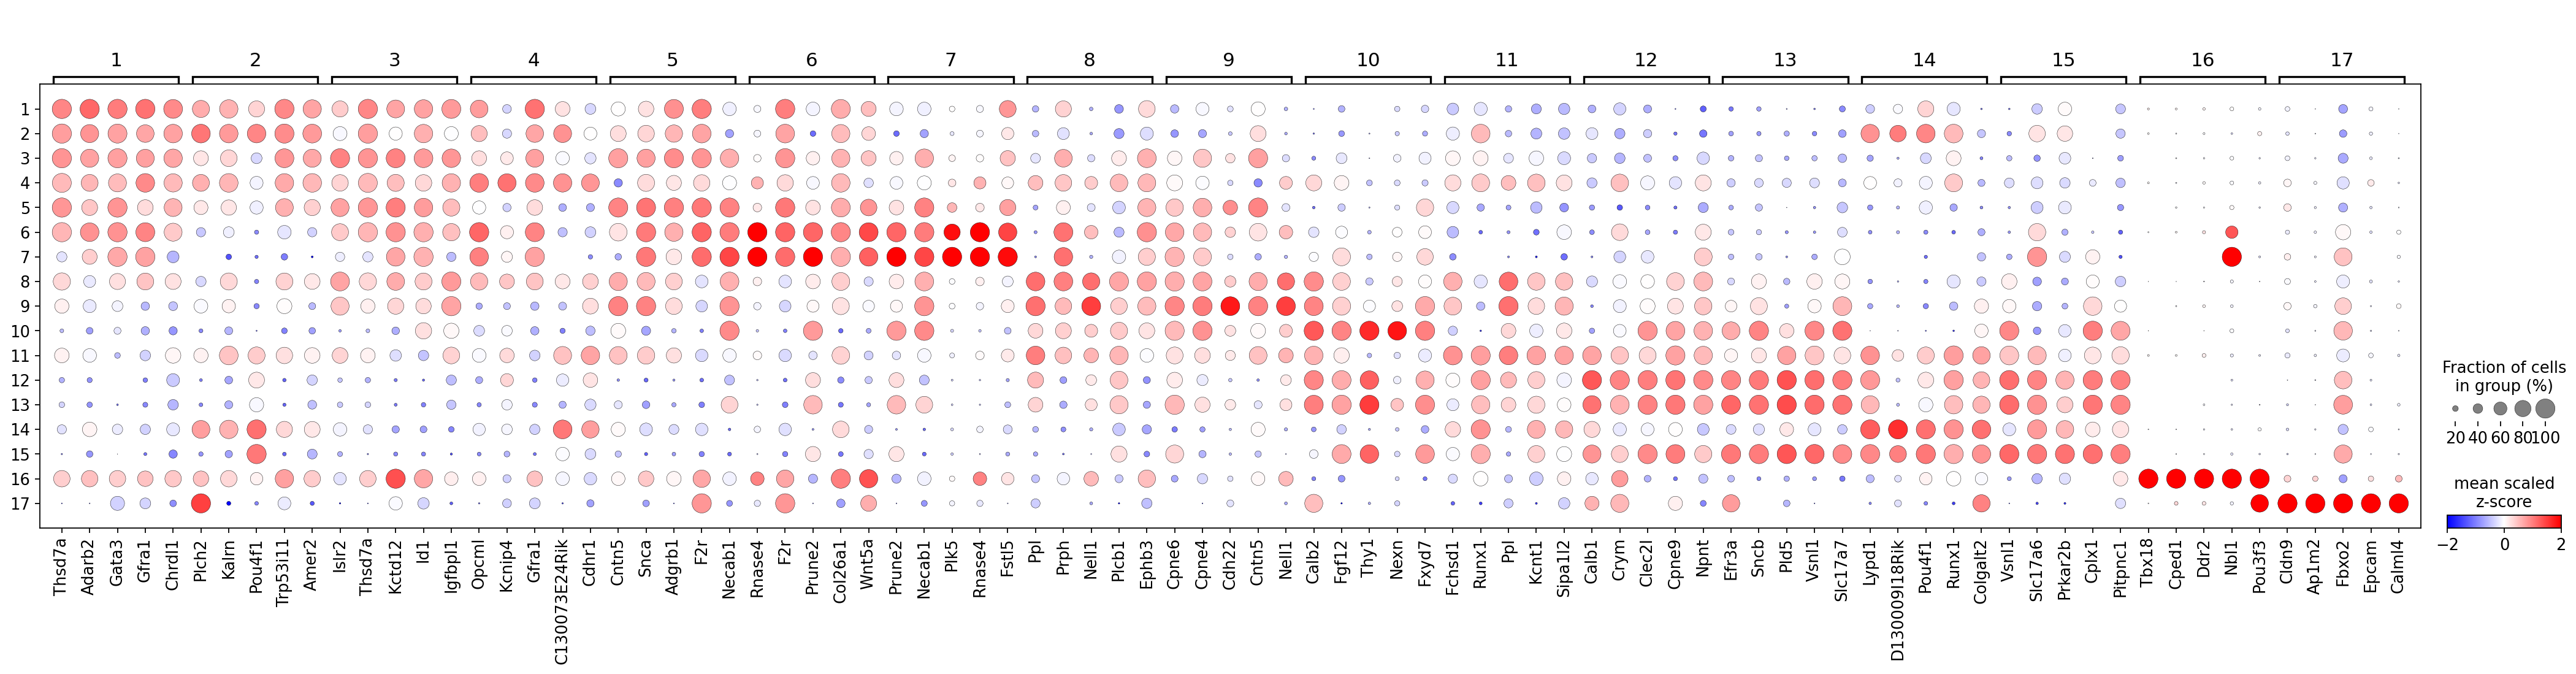

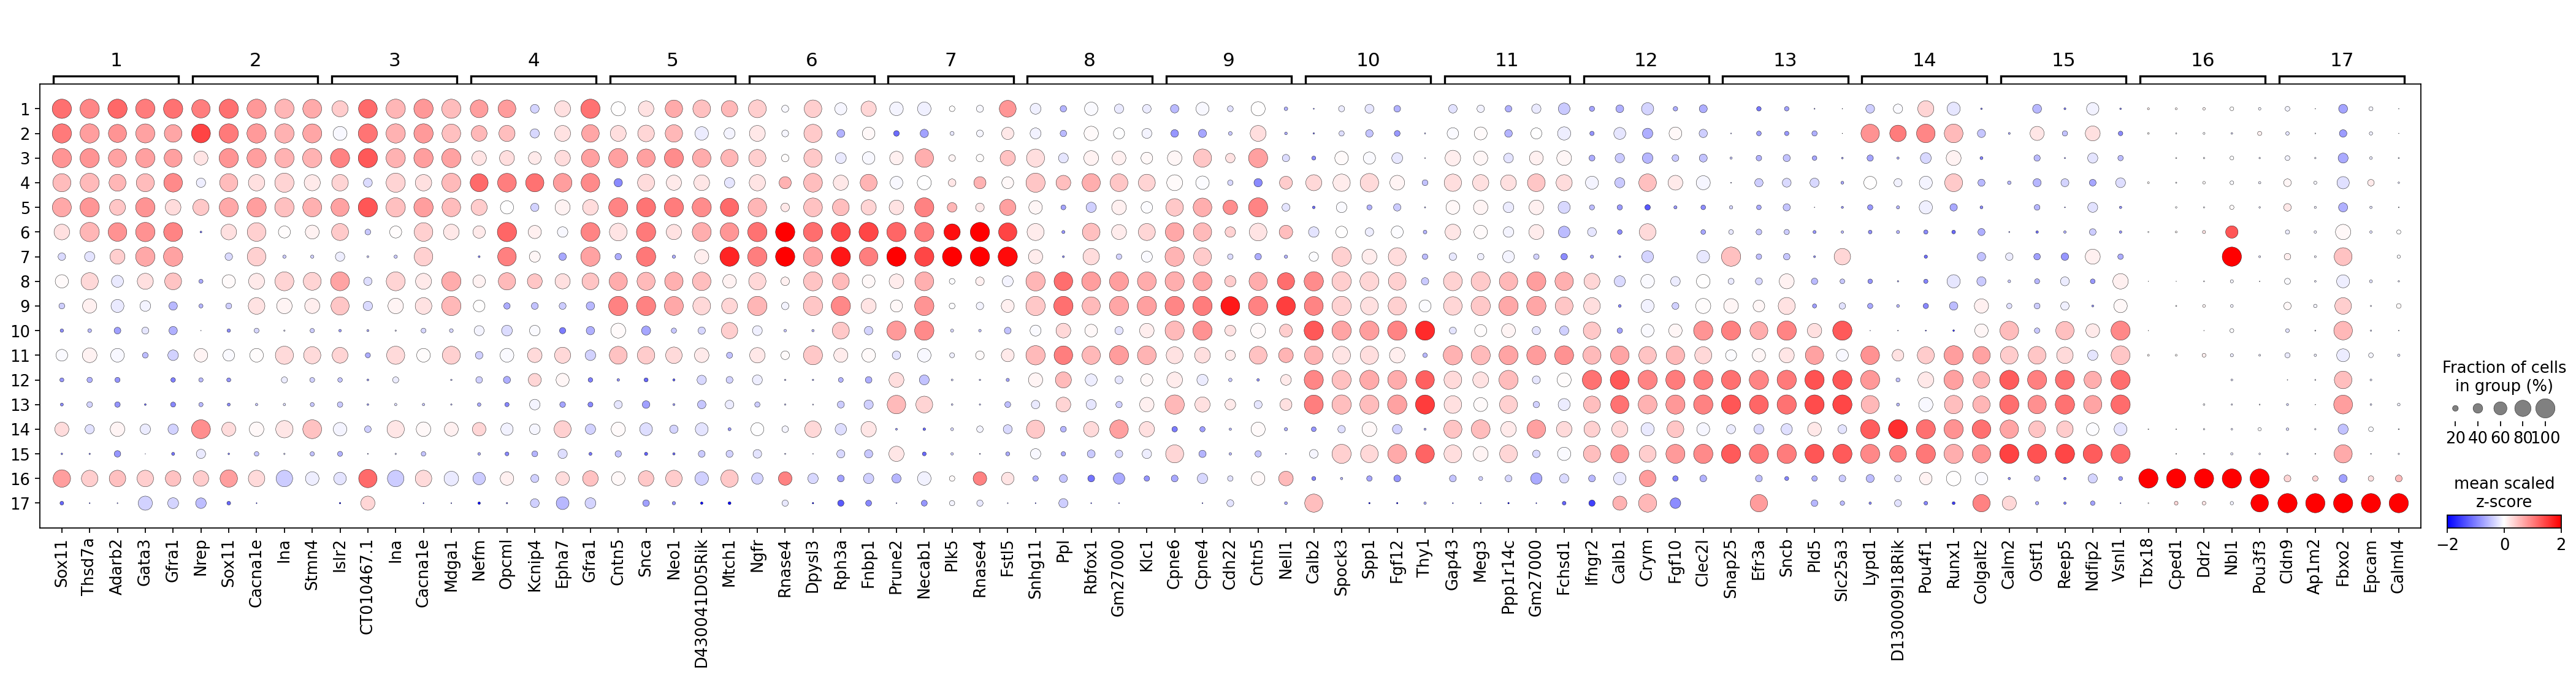

In [49]:
sc.pl.rank_genes_groups_dotplot(adata,n_genes=5,layer="scaled",cmap="bwr", colorbar_title='mean scaled\nz-score',
                                vmin=-2,vmax=2,swap_axes=False,dendrogram=False,min_logfoldchange=1,
                                save="-markers_minlogfoldchange1.png")

sc.pl.rank_genes_groups_dotplot(adata,n_genes=5,layer="scaled",cmap="bwr", colorbar_title='mean scaled\nz-score',
                                vmin=-2,vmax=2,swap_axes=False,dendrogram=False,
                               save="-markers_nofiltering.png")
#,save="SGN_E18_scaled.png",show=False)

In [63]:
import pandas as pd
df=pd.concat(list(map(lambda c: sc.get.rank_genes_groups_df(adata,str(c),log2fc_min=1).iloc[:5],adata.obs.leiden.cat.categories)),axis=0)
from itertools import chain
df["label"]=list(chain(*[[l for i in range(5)] for l in adata.obs.leiden.cat.categories]))

In [64]:
df.set_index("names").to_csv("supp_Fig1e.csv")

# Hair cells

In [37]:
%%R -o adata
load("_Output/adata_HC.RData")

... storing 'leiden' as categorical
... storing 'devtime' as categorical


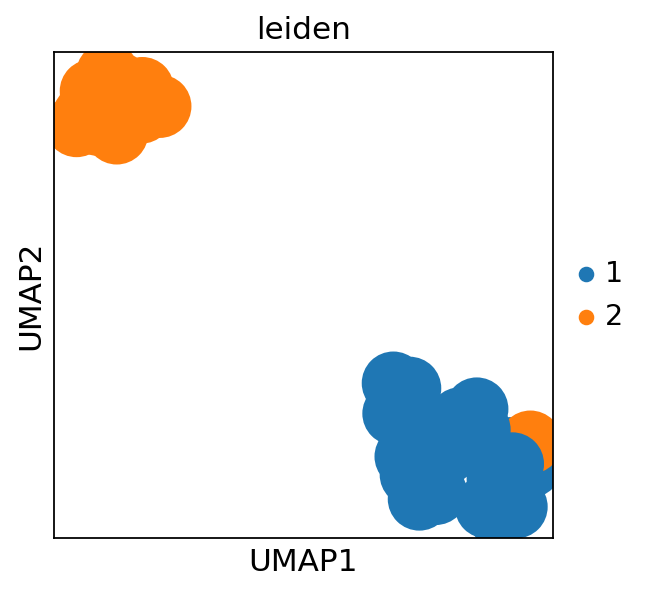

In [38]:
sc.pl.umap(adata, color='leiden')

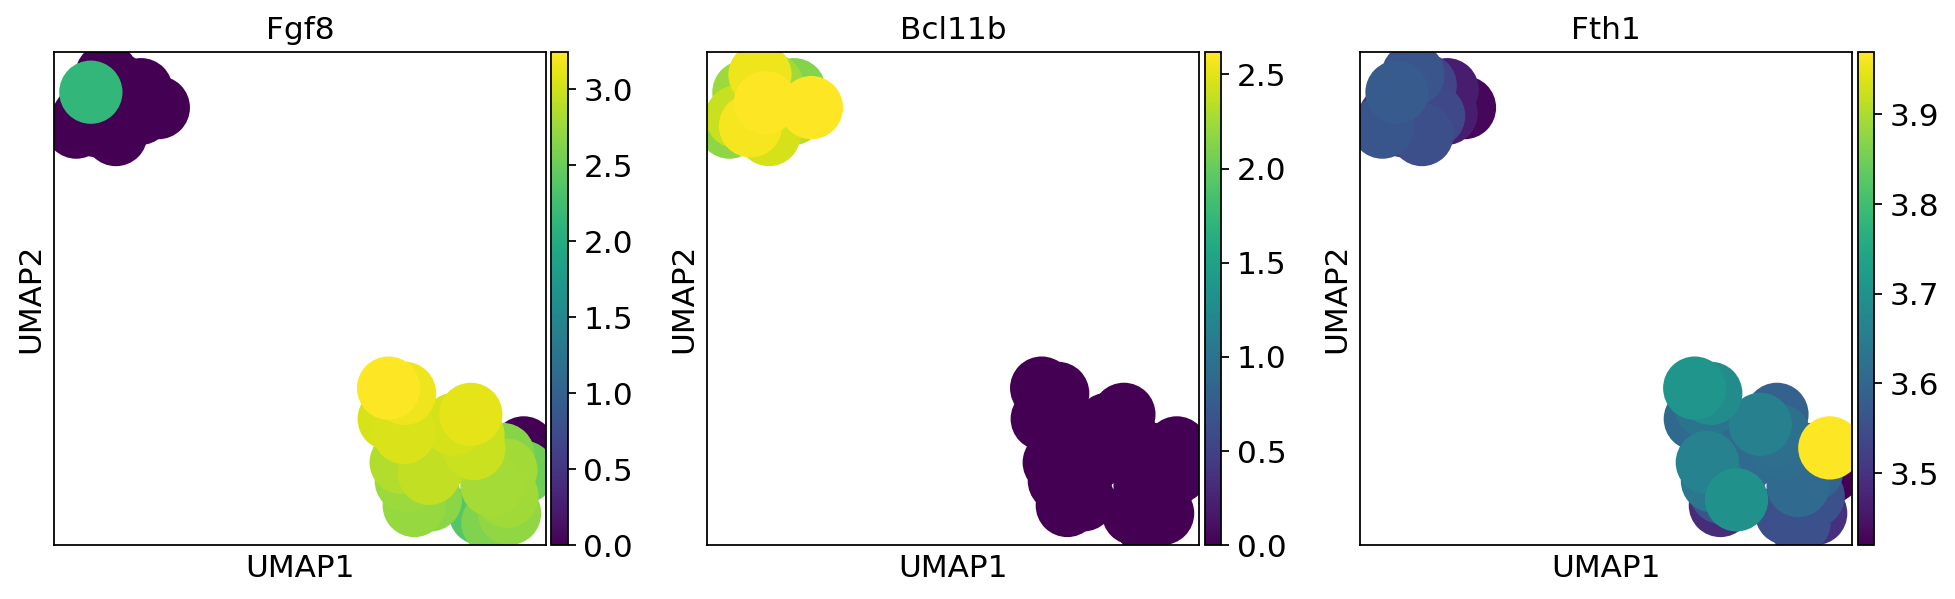

In [39]:
sc.pl.umap(adata, color=['Fgf8','Bcl11b','Fth1'])

In [40]:
adata.obs["labels"]=adata.obs.leiden

In [41]:
adata.obs["labels"]=adata.obs["labels"].cat.rename_categories(["IHC","OHC"])

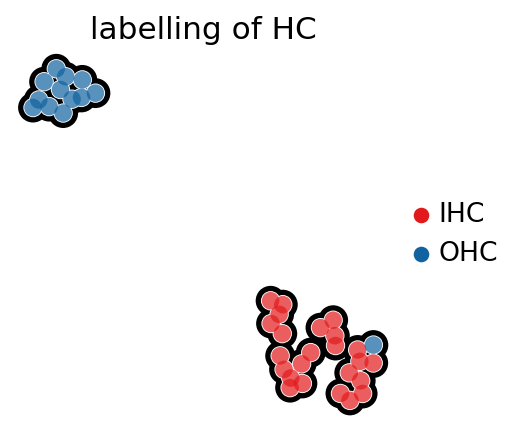

In [42]:
sc.set_figure_params(figsize=(3,3),dpi_save=600)
sc.pl.umap(adata, color='labels', add_outline=True,palette=["#E31A1C","#1162A0"],
           legend_fontsize=12, legend_fontoutline=2,frameon=False,size =250,
           title='labelling of HC',save="_HC_labeling.png")

In [43]:
fpm=pd.read_csv("_Output/fpm.csv",index_col=0)
adata=adata[:,adata.var_names.isin(fpm.index)]
adata.layers["fpm"]=fpm.loc[adata.var_names,adata.obs_names].T.values

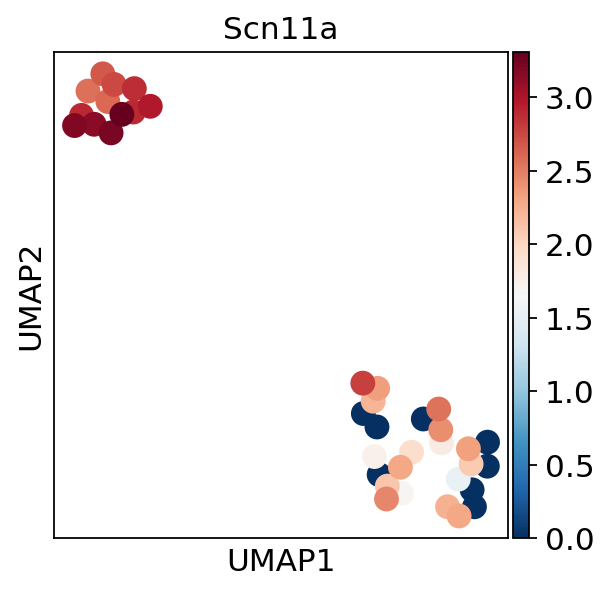

In [ ]:
sc.set_figure_params(figsize=(4,4),dpi_save=600)
sc.pl.umap(adata, color="Scn11a",size =500,color_map="RdBu_r",layer="fpm",save="HC-Scn11a.png")
sc.pl.umap(adata, color="Trh",size =500,color_map="RdBu_r",layer="fpm",save="HC-Trh.png")
sc.pl.umap(adata, color="Bcl11b",size =500,color_map="RdBu_r",layer="fpm",save="HC-Bcl11b.png")
sc.pl.umap(adata, color="Fgf8",size =500,color_map="RdBu_r",layer="fpm",save="HC-Fgf8.png")

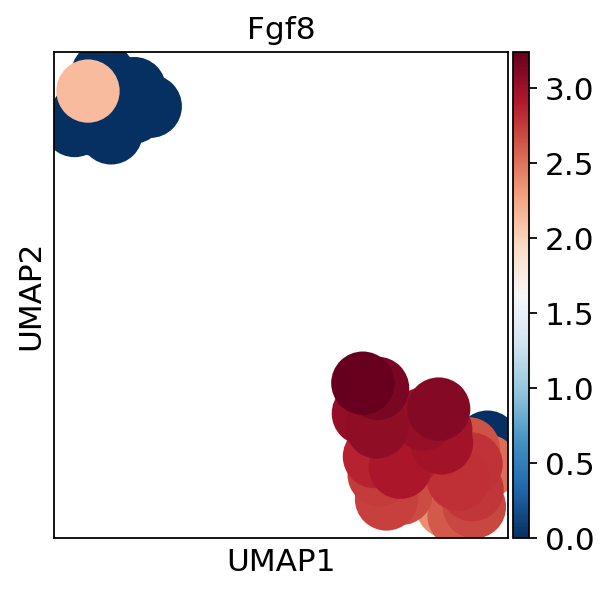

In [45]:
sc.pl.umap(adata,color="Fgf8",cmap="RdBu_r")

In [46]:
adata.write("_Output/adata_HC.h5ad")

In [25]:
adata=sc.read("_Output/adata_HC.h5ad")

In [26]:
sc.tl.rank_genes_groups(adata,"labels",method="wilcoxon",use_raw=False,layer="fpm")

In [27]:
adata.layers["scaled"]=sc.pp.scale(adata.layers["fpm"],copy=True)

/home/lfaure/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


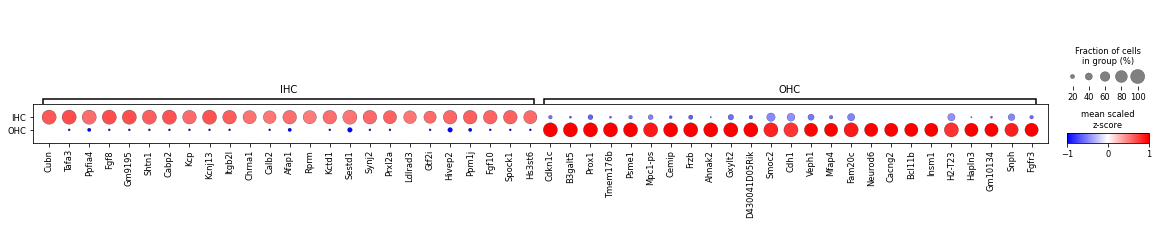

In [28]:
sc.pl.rank_genes_groups_dotplot(adata,n_genes=25,layer="scaled",cmap="bwr", colorbar_title='mean scaled\nz-score',save="_HC_scaled.png",vmin=-1,vmax=1)
#sc.pl.rank_genes_groups_dotplot(adata,n_genes=25,layer="scaled",min_logfoldchange=1,cmap="bwr", colorbar_title='mean scaled\nz-score',save="_HC_minlogfoldchange1_scaled.png",vmin=-1,vmax=1)
#sc.pl.rank_genes_groups_dotplot(adata,n_genes=25,layer="scaled",min_logfoldchange=2,cmap="bwr", colorbar_title='mean scaled\nz-score',save="_HC_minlogfoldchange2_scaled.png",vmin=-1,vmax=1)
#sc.pl.rank_genes_groups_dotplot(adata,n_genes=25,layer="scaled",min_logfoldchange=3,cmap="bwr", colorbar_title='mean scaled\nz-score',save="_HC_minlogfoldchange3_scaled.png",vmin=-1,vmax=1)

In [42]:
import pandas as pd
df=pd.concat(list(map(lambda c: sc.get.rank_genes_groups_df(adata,str(c)).loc[:24],adata.obs.labels.cat.categories)),axis=0)
from itertools import chain
df["label"]=list(chain(*[[l for i in range(25)] for l in adata.obs.labels.cat.categories]))

In [44]:
df.set_index("names").to_csv("supp_Fig4f.csv")